<a href="https://colab.research.google.com/github/Tejassorte/Python-Projects/blob/master/Podcast_Prediction_ANN_L2_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K

In [5]:
# Define custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [6]:
# Define custom MAE metric
def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true))

In [7]:
# Load data
df = pd.read_csv("/content/drive/MyDrive/Podcast listening time Prediction using ML Algo/Podcast_Prediction.csv")

In [8]:
# Handle NaNs
df['Episode_Length_minutes'].fillna(df['Episode_Length_minutes'].mean(), inplace=True)
df['Guest_Popularity_percentage'].fillna(df['Guest_Popularity_percentage'].mean(), inplace=True)
df.dropna(subset=['Number_of_Ads'], inplace=True)

/tmp/ipython-input-1589988266.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Episode_Length_minutes'].fillna(df['Episode_Length_minutes'].mean(), inplace=True)
/tmp/ipython-input-1589988266.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

In [9]:
# Sample a smaller dataset
sample_fraction = 0.2
df_small = df.sample(frac=sample_fraction, random_state=42)

In [10]:
# Features and target
X = df_small.drop(['Listening_Time_minutes', 'Episode_Title', 'id', 'Podcast_Name'], axis=1)
y = df_small['Listening_Time_minutes']

In [11]:
# Convert columns to float32
for col in ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']:
    X[col] = X[col].astype('float32')
y = y.astype('float32')

In [12]:
# Define categorical and numerical columns
categorical_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']


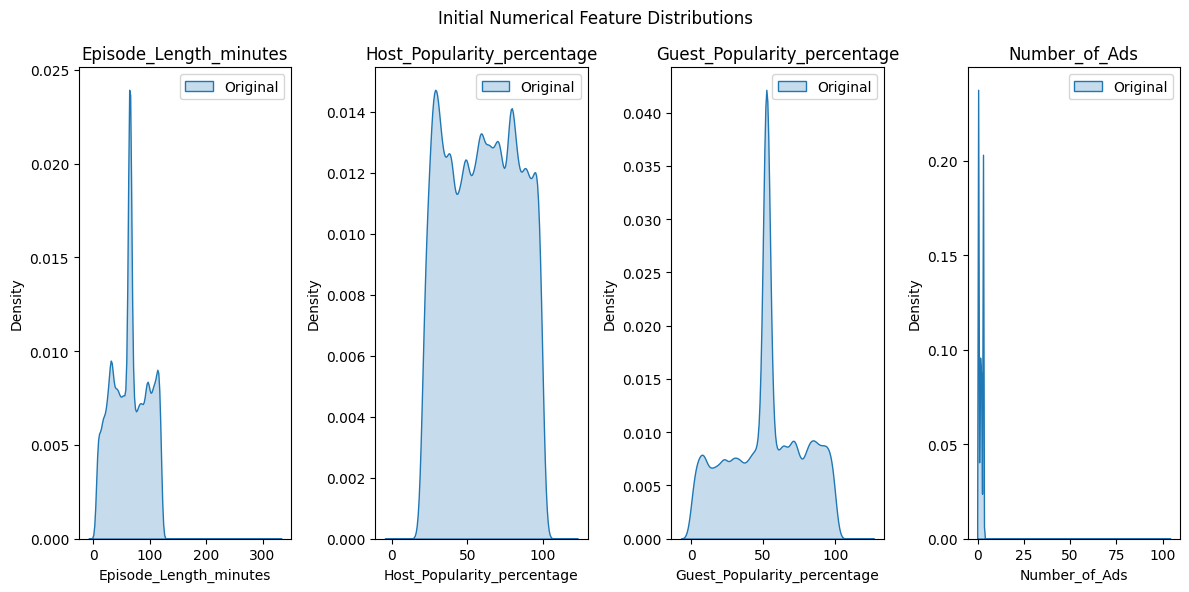

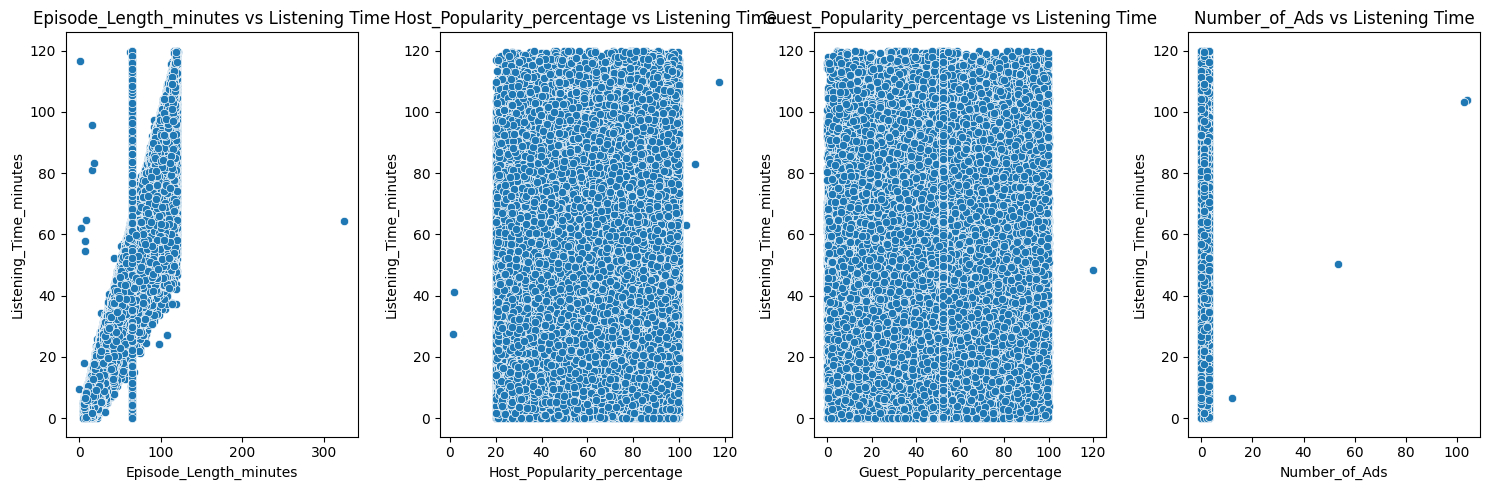

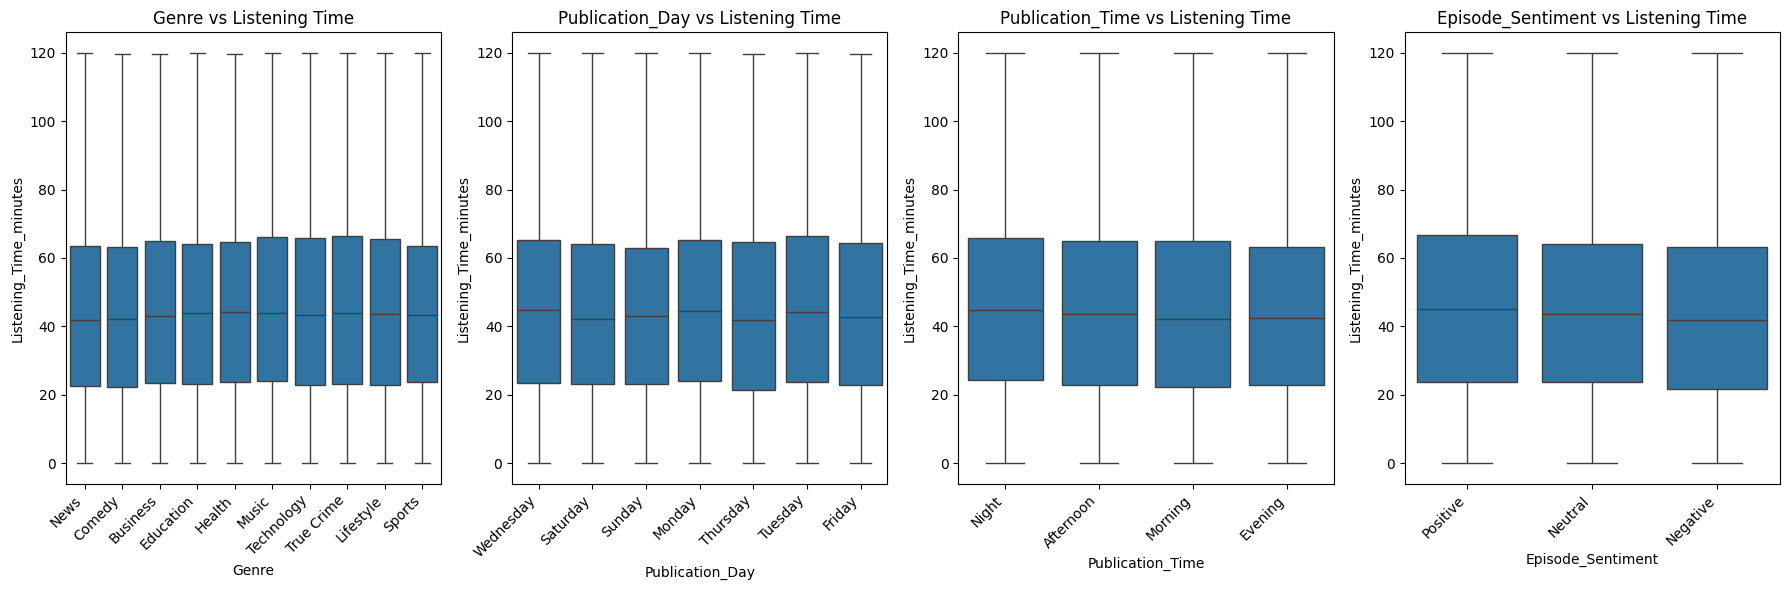

In [23]:
# Function for visualizing feature distribution before and after preprocessing
def plot_feature_distribution(original_df, processed_X, feature_names, title='Feature Distribution'):
    plt.figure(figsize=(12, 6))
    for i, feature in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i + 1)
        sns.kdeplot(original_df[feature], label='Original', fill=True)

        # Only plot processed numerical features using kdeplot
        # This part is intended for use after preprocessing where processed_X is a NumPy array
        if processed_X is not original_df and feature in numerical_cols:
             # For scaled numerical features, plot the transformed data.
             # We need to get the index of the current numerical feature within the processed numerical features.
             num_feature_index = numerical_cols.index(feature)
             # Ensure processed_X is treated as a NumPy array for slicing
             sns.kdeplot(np.asarray(processed_X)[:, num_feature_index], label='Processed', fill=True)


        plt.title(feature)
        plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage of the function to show plots from this cell
# Note: This will plot the distributions before any train-validation split or preprocessing.
# The preprocessing and plotting within the cross-validation loop will still occur later.

# Assuming X is already defined and contains the features
# Assuming numerical_cols and categorical_cols are already defined
# Assuming y is already defined and contains the target variable

# Visualize the initial numerical feature distributions using the original data (X)
plot_feature_distribution(X, X, numerical_cols, title='Initial Numerical Feature Distributions')

# Visualize the relationship between numerical features and the target variable
plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, len(numerical_cols), i + 1)
    sns.scatterplot(x=X[col], y=y)
    plt.title(f'{col} vs Listening Time')
plt.tight_layout()
plt.show()

# Visualize the relationship between categorical features and the target variable
plt.figure(figsize=(18, 6))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, len(categorical_cols), i + 1)
    sns.boxplot(x=X[col], y=y)
    plt.title(f'{col} vs Listening Time')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
# Store validation RMSEs and MAE
val_rmse_scores = []
val_mae_scores = []

Skipping plotting numerical feature distributions for training data due to insufficient dimensions after preprocessing: 0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 652.6910 - mae: 17.3633 - rmse: 21.2116 - val_loss: 181.8760 - val_mae: 9.8273 - val_rmse: 12.5988 - learning_rate: 1.0000e-04
Epoch 2/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 66s 5ms/step - loss: 219.7350 - mae: 10.8044 - rmse: 13.8726 - val_loss: 179.4417 - val_mae: 9.7660 - val_rmse: 12.5590 - learning_rate: 1.0000e-04
Epoch 3/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - loss: 216.2118 - mae: 10.6262 - rmse: 13.7278 - val_loss: 177.5685 - val_mae: 9.7025 - val_rmse: 12.5131 - learning_rate: 1.0000e-04
Epoch 4/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - loss: 208.3698 - mae: 10.5242 - rmse: 13.5786 - val_loss: 177.6076 - val_mae: 9.7240 - val_rmse: 12.5244 - learning_rate: 1.0000e-04
Epoch 5/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - loss: 206.6956 - mae: 10.4826 - rmse: 13.5503 - val_loss: 181.6633 - val_mae: 9.8450 - val_rmse: 12.6700 - learning_rate: 1.0000e-04
Epoch 6/25
12500/12500 ━━━━━━━━━━━━━━━━━

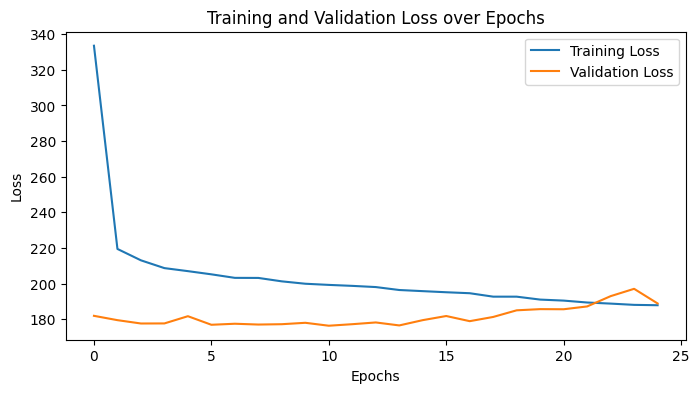

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Fold Validation RMSE: 13.224784851074219
Fold Validation MAE: 9.676960945129395
Skipping plotting numerical feature distributions for training data due to insufficient dimensions after preprocessing: 0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 74s 6ms/step - loss: 624.7659 - mae: 17.1062 - rmse: 20.9232 - val_loss: 181.7465 - val_mae: 9.8793 - val_rmse: 12.6731 - learning_rate: 1.0000e-04
Epoch 2/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 231.1541 - mae: 10.9104 - rmse: 14.0846 - val_loss: 179.3946 - val_mae: 9.7686 - val_rmse: 12.5834 - learning_rate: 1.0000e-04
Epoch 3/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - loss: 214.3684 - mae: 10.6868 - rmse: 13.7929 - val_loss: 178.3199 - val_mae: 9.7283 - val_rmse: 12.5418 - learning_rate: 1.0000e-04
Epoch 4/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - loss: 210.5765 - mae: 10.5736 - rmse: 13.6859 - val_loss: 180.1803 - val_mae: 9.7835 - val_rmse: 12.6142 - learning_rate: 1.0000e-04
Epoch 5/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - loss: 206.8986 - mae: 10.4687 - rmse: 13.5413 - val_loss: 192.6142 - val_mae: 10.1163 - val_rmse: 13.0659 - learning_rate: 1.0000e-04
Epoch 6/25
12500/12500 ━━━━━━━━━━━━━━━━

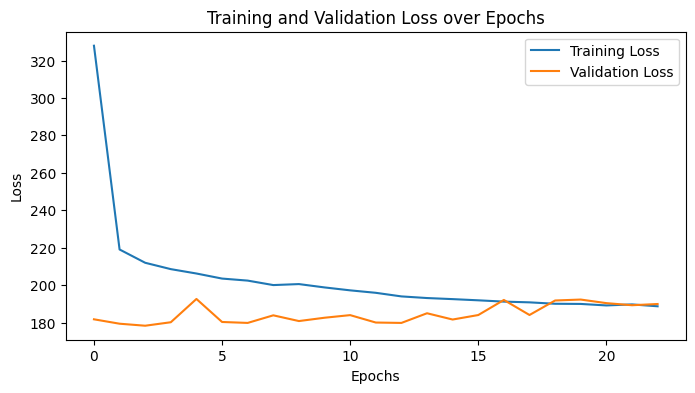

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Fold Validation RMSE: 13.288445472717285
Fold Validation MAE: 9.728302955627441
Skipping plotting numerical feature distributions for training data due to insufficient dimensions after preprocessing: 0


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 67s 5ms/step - loss: 636.0819 - mae: 17.2206 - rmse: 20.9685 - val_loss: 184.4573 - val_mae: 9.8804 - val_rmse: 12.6757 - learning_rate: 1.0000e-04
Epoch 2/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - loss: 216.8782 - mae: 10.7692 - rmse: 13.8646 - val_loss: 180.8586 - val_mae: 9.7715 - val_rmse: 12.5977 - learning_rate: 1.0000e-04
Epoch 3/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step - loss: 212.0473 - mae: 10.6126 - rmse: 13.7186 - val_loss: 179.6253 - val_mae: 9.7511 - val_rmse: 12.5761 - learning_rate: 1.0000e-04
Epoch 4/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 56s 5ms/step - loss: 208.5595 - mae: 10.5471 - rmse: 13.6434 - val_loss: 181.9212 - val_mae: 9.8394 - val_rmse: 12.6708 - learning_rate: 1.0000e-04
Epoch 5/25
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 88s 5ms/step - loss: 207.2157 - mae: 10.4966 - rmse: 13.5669 - val_loss: 181.6189 - val_mae: 9.8359 - val_rmse: 12.6654 - learning_rate: 1.0000e-04
Epoch 6/25
12500/12500 ━━━━━━━━━━━━━━━━━

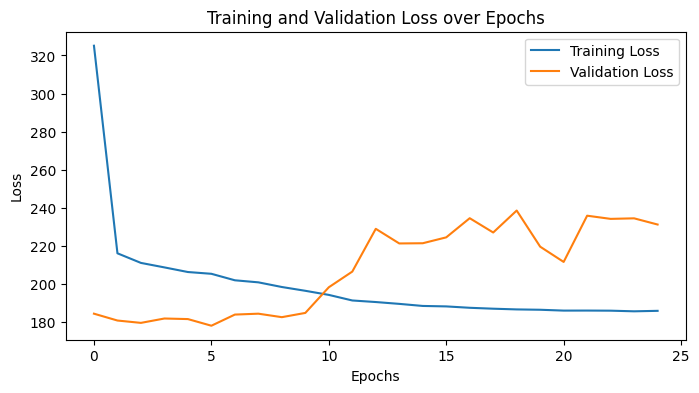

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step
Fold Validation RMSE: 13.291324615478516
Fold Validation MAE: 9.724188804626465

Average Validation RMSE across folds: 13.268184661865234
Average Validation MAE across folds: 9.709816932678223


In [32]:
# Function for visualizing feature distribution before and after preprocessing
def plot_feature_distribution(original_df, processed_X, feature_names, title='Feature Distribution'):
    plt.figure(figsize=(12, 6))
    for i, feature in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i + 1)
        sns.kdeplot(original_df[feature], label='Original', fill=True)

        # Only plot processed numerical features using kdeplot
        # This part is intended for use after preprocessing where processed_X is a NumPy array
        if processed_X is not original_df and feature in numerical_cols:
             # For scaled numerical features, plot the transformed data.
             # We need to get the index of the current numerical feature within the processed numerical features.
             num_feature_index = numerical_cols.index(feature)
             # Ensure processed_X is treated as a NumPy array for slicing
             # Add a check for dimensions before indexing
             if np.asarray(processed_X).ndim >= 2:
                 sns.kdeplot(np.asarray(processed_X)[:, num_feature_index], label='Processed', fill=True)
             else:
                 print(f"Skipping plotting for processed data due to insufficient dimensions: {np.asarray(processed_X).ndim}")


        plt.title(feature)
        plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Cross-validation setup
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Store validation RMSEs and MAE
val_rmse_scores = []
val_mae_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Preprocessing
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)

    # Visualize numerical feature distributions before and after preprocessing
    # Add a check for dimensions before calling plot_feature_distribution for processed data
    if np.asarray(X_train_processed).ndim >= 2:
        plot_feature_distribution(X_train, X_train_processed, numerical_cols, title='Numerical Feature Distributions (Training Data)')
    else:
        print(f"Skipping plotting numerical feature distributions for training data due to insufficient dimensions after preprocessing: {np.asarray(X_train_processed).ndim}")


    # Build model with L2 regularization
    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train_processed.shape[1],
              kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(1)
    ])

    # Compile model with additional metric 'mae'
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_squared_error',
                  metrics=[rmse, mae])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

    # Fit model and store history
    history = model.fit(
        X_train_processed, y_train,
        validation_data=(X_val_processed, y_val),
        epochs=25,
        batch_size=8,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Plot training & validation loss
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Epochs')
    plt.show()

    # Compute and store validation RMSE and MAE
    val_pred = model.predict(X_val_processed).flatten()
    val_rmse = np.sqrt(np.mean((val_pred - y_val) ** 2))
    val_mae = np.mean(np.abs(val_pred - y_val))
    val_rmse_scores.append(val_rmse)
    val_mae_scores.append(val_mae)
    print(f"Fold Validation RMSE: {val_rmse}")
    print(f"Fold Validation MAE: {val_mae}")

print(f"\nAverage Validation RMSE across folds: {np.mean(val_rmse_scores)}")
print(f"Average Validation MAE across folds: {np.mean(val_mae_scores)}")